In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/juan/Documents/Github_repos/ParEGO_Last_Step/core/acquisition'))
if module_path not in sys.path:
    sys.path.append(module_path)

from multi_objective import MultiObjective
import numpy as np
import matplotlib.pyplot as plt
from multi_outputGP import multi_outputGP
import GPyOpt
from pygmo import *

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
class GA:
    # Define objectives
    def __init__(self, f, bounds, n_obj):
        self.f = f
        self.bounds = bounds
        self.n_obj = n_obj
    def fitness(self, x):
        x = np.atleast_2d(x)
        output = self.f(x)
        vect_func_val = []
        for i in range(self.n_obj):
            out = output[:,i]
            vect_func_val.append(out)
        return -np.array(vect_func_val).reshape(-1)

    # Return number of objectives
    def get_nobj(self):
        return self.n_obj

    # Return bounds of decision variables
    def get_bounds(self):
        return self.bounds  # ([0]*1, [2]*1)

    # Return function name
    def get_name(self):
        return "INNER OPTIMISATION PROBLEM"
    
def mean_prediction_model(model):
    def prediction(X):
        X = np.atleast_2d(X)
        mu_x = model.posterior_mean(X)
        mu_x = np.vstack(mu_x).T
       
        return mu_x
    return prediction
    
def Generate_Pareto_Front(objective, space,model):
    X_train = model.get_X_values()
    Y_train = objective(X_train)
    
    GP_y_predictions  = mean_prediction_model(model=model)

    bounds = space.get_continuous_bounds()
    bounds = bounds_format_adapter(bounds)

    udp = GA(f=GP_y_predictions, bounds=bounds, n_obj=Y_train.shape[1])
    pop = population(prob=udp, size=100)
    algo = algorithm(nsga2(gen=100))
    pop = algo.evolve(pop)
    fits, vectors = pop.get_f(), pop.get_x()
    ndf, dl, dc, ndr = fast_non_dominated_sorting(fits)
    result_x = vectors[ndf[0]]
    result_fx = fits[ndf[0]]
    return result_fx, GP_y_predictions

def bounds_format_adapter(bounds):
    bounds = np.array(bounds)
    bounds_correct_format = []
    for b in range(bounds.shape[1]):
        bounds_correct_format.append(list(bounds[:,b]))
    return bounds_correct_format

In [3]:
# Attributes
d = 6
m = 2

# Attributes
def f(X):
    fX = np.zeros((X.shape[0], m))
    for j in range(m):
        fX[ :,j] += np.square(1 - X[:, j])
        for i in range(d):
            if i != j:
                fX[ :, j] += np.square(X[:, i])
    return -fX

In [4]:
# Utility function
def true_utility_func(y, parameter):
        #( Ntheta , Ny , Nm)
    parameter = np.atleast_2d(parameter)
    y = np.atleast_2d(y)
    utility = np.sum(y*parameter,axis=-1)
    return utility

class true_utility_func:
    def __init__(self, n_params, u_func):
        self.n_params = n_params
        self.u_func = u_func
        
    def __call__(self, y, parameter):
        utility = self.u_func(y, parameter)
        return utility

class Linear_utility_func:
    def __init__(self, n_params):
        self.n_params = n_params

    def __call__(self, y, parameter):
        #( Ntheta , Ny , Nm)
        parameter = np.atleast_2d(parameter)[:,np.newaxis,:]
        y = np.atleast_2d(y)[np.newaxis,:,:]
        utility = np.sum(y*parameter,axis=-1)
        return utility

class Tchevichev_utility_func:
    
    def __init__(self, n_params):
        self.n_params = n_params
    
    def __call__(self, y, parameter):
        parameter = np.atleast_2d(parameter)[:,np.newaxis,:]
        y = np.atleast_2d(y)[np.newaxis,:,:]
        scaled_vectors = parameter * y
        utility = np.min(scaled_vectors, axis=-1)
        return utility


class composed_utility_functions:
    
    def __init__(self, u_funcs):
        self.u_funcs = u_funcs

    def __call__(self, y, weights, parameters):
        
        
        y = np.atleast_2d(y)
        weights = np.atleast_2d(weights)
        parameters = np.atleast_2d(parameters)
        
        util = np.zeros((weights.shape[0], y.shape[0] , len(self.u_funcs)))
        
        for ufun in range(len(self.u_funcs)):
            out = self.u_funcs[ufun](y, parameters[ufun])
#             print(out.shape)
#             print("util",util.shape)
            util[:,:,ufun] = out
        
#         print("parameters",parameters, "len", len(parameters))
#         print("weight", weights, "shape", weights.shape)
        
        total_utility = np.sum(util * weights[:,np.newaxis,  :], axis=-1)
#         print("total_utility",total_utility.shape)
        return total_utility

class prior_sample_generator:
    def __init__(self, u_funcs):
        self.u_funcs = u_funcs
        self.wdim = len(u_funcs)
        self.tindvdim = [u.n_params for u in u_funcs]
        self.tdim = np.sum([u.n_params for u in u_funcs])
        
    def __call__(self, n_samples=1, seed=None):
        
        if seed is None:
            theta_samples = [self.dirich_sampler(dim=d, n_samples=n_samples) for d in self.tindvdim]
            weight_samples =self.dirich_sampler(self.wdim, n_samples=n_samples)
        else:
            
            theta_samples = [self.dirich_sampler(d, n_samples=n_samples, seed=seed) for d in self.tindvdim]
            weight_samples =self.dirich_sampler(self.wdim, n_samples=n_samples, seed=seed)
        
        return theta_samples, weight_samples
    
    
    def dirich_sampler(self,dim, n_samples=1, seed=None):
        
        if seed is None:
            samples = np.random.dirichlet(np.ones((dim, )), n_samples)
        else:
            random_state = np.random.RandomState(seed)
            samples = random_state.dirichlet(np.ones((dim, )), n_samples)
        return samples

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-2.64952184]
 [-1.21410203]
 [-1.31998765]
 [-1.50044955]
 [-1.9866956 ]
 [-2.13446346]
 [-0.99785233]
 [-1.99321295]
 [-1.08258551]
 [-2.40888486]
 [-1.58667527]
 [-2.8380613 ]
 [-0.70726807]
 [-1.99396499]
 [-2.52687941]
 [-2.84070632]
 [-1.17580405]
 [-2.25793404]
 [-1.14705368]
 [-2.25882175]
 [-2.31330527]
 [-1.12773178]
 [-2.28981399]
 [-1.84436165]
 [-2.00627171]
 [-2.85299454]
 [-1.85290725]
 [-1.87013719]
 [-2.38879481]
 [-1.86146635]
 [-2.77992436]
 [-1.85014788]
 [-1.17920784]
 [-0.51870534]
 [-1.96870007]
 [-0.95725296]
 [-1.0433683 ]
 [-1.70703218]
 [-1.54276851]
 [-2.17549411]
 [-0.79815459]
 [-2.32884986]
 [-2.13760622]
 [-2.98799604]
 [-1.98784479]
 [-2.18226949]
 [-1.61825508]
 [-3.18705945]
 [-1.47548244]
 [-2.46144241]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -6.841366769797297
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  Mat32.variance           |      5.073954861037015  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |      5.601357845747172  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.0040934430974242045  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-2.334822  ]
 [-1.0507869 ]
 [-2.06130118]
 [-1.18875205]
 [-1.51536411]
 [-2.74168696]
 [-1.18899261]
 [-1.94809856]
 [-0.72929638]
 [-2.6517035 ]
 [-0.99760591]
 [-2.47576832]
 [-1.20496913]
 [-2.09747829]
 [-2.80806362]
 [-3.33286541]
 [-1.71125401]
 [-1.88361072]
 [-1.42768998]
 [-0.62128272]
 [-1.27063572]
 [-2.16958969]
 [-1.6964108 ]
 [-2.39639222]
 [-1.71335935]
 [-2.64146726]
 [-3.06074988]
 [-2.30276311]
 [-1.15717157]
 [-2.74922572]
 [-3.20845644]
 [-1.82985941]
 [-2.

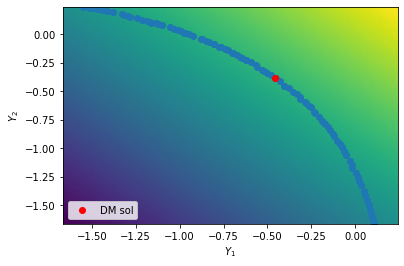

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-2.5151792 ]
 [-1.71731503]
 [-1.21623152]
 [-2.86240136]
 [-0.94863143]
 [-0.81516375]
 [-0.7735876 ]
 [-2.7749995 ]
 [-2.34894032]
 [-1.64447302]
 [-1.11306149]
 [-2.81708076]
 [-1.85022014]
 [-2.48628485]
 [-1.60265802]
 [-2.06800168]
 [-1.1832071 ]
 [-1.30726358]
 [-1.51475894]
 [-2.65618252]
 [-2.05426433]
 [-2.52188101]
 [-1.56148471]
 [-1.53371747]
 [-2.18195457]
 [-3.12066722]
 [-3.14989906]
 [-1.05184685]
 [-1.31440275]
 [-1.59549088]
 [-3.13692101]
 [-1.98031708]
 [-4.46620048]
 [-2.93740547]
 [-1.87894393]
 [-3.12969957]
 [-2.64347786]
 [-1.31078135]
 [-1.86683768]
 [-2.27238115]
 [-3.25112046]
 [-2.58479494]
 [-1.64173004]
 [-2.3295985 ]
 [-1.12436067]
 [-2.22787957]
 [-1.28136759]
 [-2.49117381]
 [-1.30760973]
 [-1.91530453]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -1.3049859451124544
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  Mat32.variance           |     6.087879417852956  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |     5.473787515413524  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.005945928641992974  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-2.11468026]
 [-3.09380517]
 [-2.46603471]
 [-2.3510056 ]
 [-1.03028006]
 [-1.52694779]
 [-1.2740514 ]
 [-1.89753507]
 [-2.34678482]
 [-3.16453422]
 [-0.76263105]
 [-2.00987299]
 [-0.8333349 ]
 [-2.94141834]
 [-2.62233552]
 [-1.21345945]
 [-1.996626  ]
 [-2.02689125]
 [-2.00072074]
 [-2.36839312]
 [-1.22760964]
 [-1.41419119]
 [-0.94869209]
 [-2.06632929]
 [-1.67732453]
 [-3.02946985]
 [-2.47961239]
 [-1.6678759 ]
 [-1.27459009]
 [-2.02893035]
 [-1.88255943]
 [-1.63582237]
 [-3.500

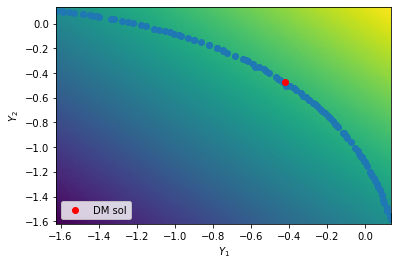

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-1.27259167]
 [-2.12169985]
 [-2.6498498 ]
 [-1.14671765]
 [-1.68567842]
 [-2.20256727]
 [-1.43095429]
 [-0.80688713]
 [-2.27797012]
 [-1.65310742]
 [-2.46796337]
 [-1.84310165]
 [-2.66093994]
 [-1.43248372]
 [-0.67253867]
 [-2.1171967 ]
 [-1.64609339]
 [-0.52412008]
 [-2.95103445]
 [-1.7571523 ]
 [-2.37018738]
 [-0.54427063]
 [-2.01749038]
 [-2.97392459]
 [-1.44996222]
 [-1.93105956]
 [-2.94314546]
 [-0.94886666]
 [-2.85937203]
 [-2.02402122]
 [-2.30011169]
 [-2.05228558]
 [-2.36090132]
 [-2.88008414]
 [-3.82180423]
 [-1.66321515]
 [-1.35193149]
 [-2.09019436]
 [-1.26936472]
 [-2.53690377]
 [-3.01145945]
 [-0.3959346 ]
 [-2.2099334 ]
 [-3.61469908]
 [-1.86010223]
 [-1.11778889]
 [-1.0632062 ]
 [-1.87735869]
 [-1.92430312]
 [-1.87356066]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -2.9875795984663593
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  Mat32.variance           |     5.361824430745547  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |      5.46254788936785  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.005897338757295706  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-1.65771963]
 [-2.51429371]
 [-3.13850301]
 [-1.39424663]
 [-1.847047  ]
 [-1.86223201]
 [-1.0164275 ]
 [-0.54864417]
 [-2.66301464]
 [-0.84436913]
 [-1.49372924]
 [-2.8371899 ]
 [-3.80910481]
 [-1.6154354 ]
 [-2.5895624 ]
 [-2.77629314]
 [-1.3984019 ]
 [-1.61402626]
 [-3.27614707]
 [-2.99822657]
 [-1.66045413]
 [-1.42506144]
 [-1.0101144 ]
 [-2.12965242]
 [-1.79901996]
 [-2.13210441]
 [-1.72621354]
 [-0.85798337]
 [-2.97818906]
 [-1.16442236]
 [-2.48640239]
 [-0.68555806]
 [-2.020

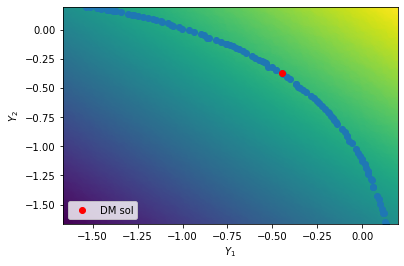

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-1.97989912]
 [-0.69507969]
 [-2.16466968]
 [-1.89830169]
 [-1.98223566]
 [-2.51632177]
 [-1.1335927 ]
 [-0.95063221]
 [-2.69796876]
 [-2.88557486]
 [-2.41799759]
 [-1.532436  ]
 [-1.97049976]
 [-2.34540974]
 [-3.40877996]
 [-3.76213868]
 [-1.76978771]
 [-3.1184368 ]
 [-0.6812932 ]
 [-0.83595488]
 [-2.81904448]
 [-1.56519886]
 [-1.09762069]
 [-2.59510007]
 [-1.54899503]
 [-2.3914728 ]
 [-1.76275668]
 [-2.32397523]
 [-1.91801842]
 [-2.33750013]
 [-2.09007741]
 [-2.3038634 ]
 [-1.47613619]
 [-2.11445251]
 [-2.89267685]
 [-1.37113333]
 [-2.41232294]
 [-1.05488116]
 [-2.3771589 ]
 [-2.24005166]
 [-2.26138003]
 [-3.10499144]
 [-1.89142217]
 [-1.43440362]
 [-1.47414063]
 [-1.44230681]
 [-3.59023978]
 [-2.64486906]
 [-1.22519081]
 [-1.7096255 ]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -4.0083803715766315
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  Mat32.variance           |     5.843768827491044  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |     5.618642752831995  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.005276372031184896  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-2.08500542]
 [-0.88841867]
 [-2.34281258]
 [-1.59301185]
 [-1.56215467]
 [-2.59511141]
 [-1.16818467]
 [-1.01548271]
 [-3.47522675]
 [-2.33120019]
 [-3.11132267]
 [-0.99860526]
 [-3.17565598]
 [-1.78450239]
 [-2.80512725]
 [-2.24624943]
 [-1.7029188 ]
 [-1.81299977]
 [-1.19489248]
 [-1.88706034]
 [-3.08624057]
 [-2.95945475]
 [-1.43788081]
 [-1.98675083]
 [-1.69922313]
 [-1.6708625 ]
 [-1.92196736]
 [-0.79973938]
 [-1.58908131]
 [-2.02140002]
 [-2.51606503]
 [-2.05526536]
 [-1.323

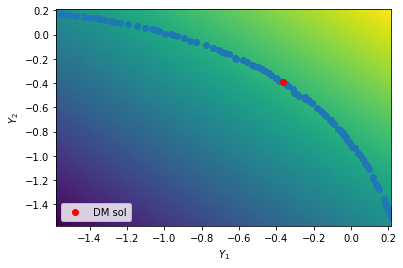

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-1.34765471]
 [-3.07537791]
 [-1.66097408]
 [-0.88985534]
 [-2.2686338 ]
 [-1.3529692 ]
 [-2.02264294]
 [-1.88834821]
 [-1.45596174]
 [-1.99870365]
 [-2.23636275]
 [-1.5523358 ]
 [-1.93255697]
 [-2.21919772]
 [-2.60257459]
 [-1.87840956]
 [-1.15704176]
 [-1.57860349]
 [-1.99785518]
 [-1.15195279]
 [-2.47169911]
 [-3.04550596]
 [-2.40971631]
 [-1.37283294]
 [-1.86541764]
 [-1.58644922]
 [-1.64022427]
 [-2.64254488]
 [-2.83532768]
 [-1.71198201]
 [-1.97961057]
 [-2.15679467]
 [-3.15599079]
 [-2.91752912]
 [-1.89361723]
 [-0.86531347]
 [-0.50216538]
 [-2.1424034 ]
 [-1.46962057]
 [-1.02312249]
 [-2.22549758]
 [-1.99906973]
 [-1.18855165]
 [-1.57178453]
 [-1.76222005]
 [-1.12379021]
 [-1.565564  ]
 [-1.21283559]
 [-2.62065965]
 [-1.49059231]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -7.744062846625175
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  Mat32.variance           |     5.523648615638897  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |     5.784622482961522  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.003704515041945978  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-1.45740376]
 [-2.50226094]
 [-1.99852834]
 [-1.56475816]
 [-2.30100167]
 [-2.18481584]
 [-0.71869124]
 [-0.84047476]
 [-2.03564001]
 [-2.14264675]
 [-3.82146635]
 [-1.57293587]
 [-1.78025761]
 [-1.23691878]
 [-2.74254774]
 [-2.49233939]
 [-1.38486501]
 [-2.37876899]
 [-1.17015804]
 [-2.53493718]
 [-1.80217469]
 [-2.52506045]
 [-2.02833461]
 [-1.23147454]
 [-1.63570777]
 [-1.44900274]
 [-0.54831901]
 [-3.35517725]
 [-2.16878945]
 [-2.08825919]
 [-1.78851582]
 [-1.95106419]
 [-1.7265

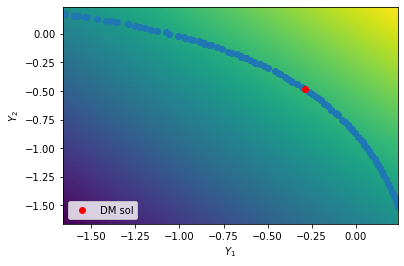

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-1.40983946]
 [-2.22162686]
 [-2.50636132]
 [-2.20344615]
 [-1.96279622]
 [-1.43549358]
 [-1.66279772]
 [-3.31844897]
 [-4.44524759]
 [-1.30553539]
 [-2.07064835]
 [-1.69846725]
 [-1.65882143]
 [-0.85707287]
 [-1.97710738]
 [-3.00769893]
 [-2.12813971]
 [-3.39385512]
 [-1.335704  ]
 [-1.27597862]
 [-1.37394869]
 [-1.442565  ]
 [-0.42163232]
 [-1.98084588]
 [-2.45227665]
 [-1.87315446]
 [-2.23528769]
 [-2.05644251]
 [-1.33638332]
 [-1.93846677]
 [-4.66342563]
 [-2.48106443]
 [-3.29573272]
 [-2.59737885]
 [-1.98816803]
 [-1.73885867]
 [-3.0382904 ]
 [-3.19901681]
 [-2.54526435]
 [-1.27728294]
 [-0.95633706]
 [-1.63331347]
 [-1.65632502]
 [-2.50657868]
 [-1.96259671]
 [-2.72174081]
 [-2.10703663]
 [-2.62677082]
 [-3.5124484 ]
 [-2.07313944]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : 2.443881418047905
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors  
  Mat32.variance           |   6.3872980634278855  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |    5.490815313041707  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.00702863867493177  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-1.63543244]
 [-2.47952219]
 [-1.98762242]
 [-1.17439035]
 [-2.37358579]
 [-2.22265283]
 [-1.83039681]
 [-2.01044451]
 [-3.42417014]
 [-1.96214954]
 [-1.47705101]
 [-2.40451942]
 [-3.31421061]
 [-1.23959752]
 [-1.74293739]
 [-2.05592828]
 [-3.48525113]
 [-2.22580214]
 [-0.83753398]
 [-1.26857596]
 [-2.04547057]
 [-1.29576354]
 [-1.01888737]
 [-1.87695031]
 [-3.6097293 ]
 [-2.23339613]
 [-1.66888566]
 [-1.89570106]
 [-2.10825973]
 [-1.28199669]
 [-2.8697483 ]
 [-2.14567474]
 [-3.50832479]

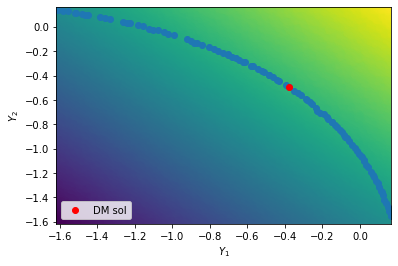

reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


create model
matern kernel
Y [[-1.47991289]
 [-1.21960115]
 [-2.55958679]
 [-2.26006162]
 [-1.08585829]
 [-2.18721561]
 [-0.97426569]
 [-2.82379896]
 [-1.65673917]
 [-1.36718373]
 [-2.43630162]
 [-1.26811009]
 [-2.57222429]
 [-1.56679568]
 [-2.35880257]
 [-2.35433026]
 [-1.89117596]
 [-2.6962133 ]
 [-1.39705548]
 [-1.60267248]
 [-1.87236377]
 [-1.79991683]
 [-4.45641939]
 [-3.29623035]
 [-1.18433187]
 [-0.75326304]
 [-2.56789795]
 [-1.65335815]
 [-0.73441073]
 [-1.46455317]
 [-3.06169178]
 [-2.77203842]
 [-2.70789205]
 [-2.86883398]
 [-2.54605065]
 [-1.23525547]
 [-2.19988326]
 [-2.00465503]
 [-1.88931585]
 [-1.76919651]
 [-1.99627439]
 [-0.78791614]
 [-0.83171291]
 [-2.04767836]
 [-1.58291204]
 [-2.22951956]
 [-2.07937377]
 [-1.54153274]
 [-0.86215436]
 [-2.71239417]]


reconstraining parameters GP_regression.Mat32
reconstraining parameters GP_regression.Gaussian_noise.variance


self.model 
Name : GP regression
Objective : -2.1487225379923256
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  Mat32.variance           |      5.862451588865398  |      +ve      |  Ga(1, 0.5)
  Mat32.lengthscale        |      5.645076121662987  |      +ve      |  Ga(1, 0.5)
  Gaussian_noise.variance  |  0.0056229414768578425  |   +ve fixed   |  Ga(1, 0.5)
create model
matern kernel
Y [[-2.42492073]
 [-1.41268895]
 [-2.20860397]
 [-1.17487563]
 [-2.25299685]
 [-2.33629412]
 [-2.24227048]
 [-4.01906329]
 [-1.08834473]
 [-1.90378009]
 [-1.41462095]
 [-2.79609813]
 [-2.19225386]
 [-2.45696379]
 [-2.94085154]
 [-1.82382469]
 [-2.78919276]
 [-3.15335756]
 [-0.23135856]
 [-1.81683449]
 [-1.71499989]
 [-1.4264427 ]
 [-2.47998226]
 [-2.35549985]
 [-1.39629473]
 [-0.65687215]
 [-1.39746273]
 [-2.36390332]
 [-1.4667549 ]
 [-1.04391192]
 [-2.29407633]
 [-2.9997317 ]
 [-2

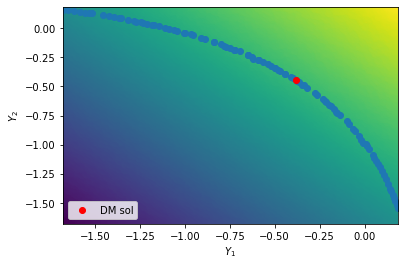

In [53]:
def generate_pf_dm_samples(Nfronts, true_utility, objective,initial_design= 5, seed=1):
    np.random.seed(seed)
    PF_samples = []
    PF_decisions = []
            
    prior_sample_gen = prior_sample_generator(u_funcs)
    true_dm_theta_samples, true_dm_weight_samples = [np.array([[0.5, 0.5]])], [[1.]]#prior_sample_gen(n_samples=1, seed=seed)
#     print(true_dm_theta_samples, true_dm_weight_samples )
#     raise
    for n in range(Nfronts):
        initial_n_samples = initial_design
        X_train = np.random.random((initial_n_samples, d))
        y_train = objective(X_train)
        space = GPyOpt.Design_space(space=[{'name': 'var', 'type': 'continuous', 'domain': (0, 1), 'dimensionality': d}])
        model = multi_outputGP(output_dim=m, exact_feval=[True] * m)
        
        X_inmodel = space.unzip_inputs(X_train)
        Y_inmodel = [np.atleast_2d(y).T for y in y_train.T.tolist()]
        
        model.updateModel(X_inmodel, Y_inmodel)
        result_fx, _ = Generate_Pareto_Front(objective=f, space = space, model=model)
        results_fx = -result_fx
        
        
        uindex = np.argmax(true_utility(y=results_fx,  
                                        weights= true_dm_weight_samples, 
                                        parameters=true_dm_theta_samples))
        
        chosen_choice = uindex#results_fx[uindex]
#         results_fx = np.delete(results_fx,uindex , axis=0)

        PF_samples.append(results_fx)
        
        PF_decisions.append(chosen_choice)
        
        ub = np.max([np.max(results_fx[:,0]),np.max(results_fx[:,1])])
        lb = np.min([np.min(results_fx[:,0]), np.min(results_fx[:,1])])
        Y = np.random.random((100000,2))*(ub - lb) + lb
        
        print("param", true_dm_theta_samples)
        Z = true_utility(y=Y,  
                        weights= true_dm_weight_samples, 
                        parameters=true_dm_theta_samples)
        
        im = plt.scatter(Y[:,0], Y[:,1], c=Z.reshape(-1), alpha=0.3)
        plt.scatter(results_fx[:,0], results_fx[:,1])
        plt.scatter(results_fx[chosen_choice,0], results_fx[chosen_choice,1], color="red", label="DM sol")
        
#         plt.colorbar(im)
        plt.xlim((lb, ub))
        plt.ylim((lb, ub))
        plt.legend(loc="lower left")
        plt.xlabel("$Y_{1}$")
        plt.ylabel("$Y_{2}$")
#         plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/dm_choose.png",bbox_inches='tight')
#         raise
        plt.show()
        
    return true_dm_theta_samples, true_dm_weight_samples, PF_samples, PF_decisions

Lin_u = Linear_utility_func(n_params=m)
Tche_u = Tchevichev_utility_func(n_params=m)
u_funcs = [Lin_u]
true_ufunc = composed_utility_functions(u_funcs)
true_theta, true_weight, PF_samples, PF_decisions = generate_pf_dm_samples(Nfronts=7, true_utility=true_ufunc, objective=f, initial_design= 50, seed=3)

In [99]:
from scipy.stats import dirichlet
from scipy.stats import norm

class Inference_method():
    def __init__(self, u_funcs, Pareto_front, preferred_points):
        self.u_funcs = u_funcs
        self.wdim = len(u_funcs)
        self.tindvdim = [u.n_params for u in u_funcs]
        self.tdim = np.sum([u.n_params for u in u_funcs])
        self.m_dim = self.tdim + self.wdim
        self.u_function = composed_utility_functions(u_funcs)
        self.Pareto_front =Pareto_front
        self.preferred_points= preferred_points
        
    def prior(self, theta, weights):
        
        t_arr = np.hstack(theta)
        w_arr = weights
        param_arr = np.hstack([t_arr, w_arr])
        
        assert param_arr.shape[1] == self.m_dim, "wrong dimension"
        output_w = np.zeros((w_arr.shape[0], 1))
        
        for i in range(w_arr.shape[0]):
            try:
                output_w[i] = dirichlet.pdf(x=w_arr[i], alpha=np.ones((self.wdim, )))
            except:
                output_w[i] = 0
     
        output_t = np.zeros((w_arr.shape[0],self.wdim))   
        for i in range(len(self.tindvdim)):
            for j in range(len(theta[i])):
                try:
                    output_t[j,i ] = dirichlet.pdf(x=theta[i][j], alpha=np.ones((self.tindvdim[i], )))
                except:
                    output_t[j,i ] = 0 
        
        concat_vals = np.hstack([output_w,output_t])
        prior_fval = np.product(concat_vals,axis=1)
        return prior_fval

                    
        
    def prior_sampler(self, n_samples, seed=None):
        if seed is None:
            theta_samples = [self.dirich_sampler(dim=d, n_samples=n_samples) for d in self.tindvdim]
            weight_samples =self.dirich_sampler(self.wdim, n_samples=n_samples)
        else:
            
            theta_samples = [self.dirich_sampler(d, n_samples=n_samples, seed=seed) for d in self.tindvdim]
            weight_samples =self.dirich_sampler(self.wdim, n_samples=n_samples, seed=seed)
        
        return theta_samples, weight_samples
        
    def dirich_sampler(self,dim, n_samples=1, seed=None):
        
        if seed is None:
            samples = np.random.dirichlet(np.ones((dim, )), n_samples)
        else:
            random_state = np.random.RandomState(seed)
            samples = random_state.dirichlet(np.ones((dim, )), n_samples)
        return samples
    
        
    def predictive_distribution(self,current_front, 
                                preferred_point):
        
        
        posterior_theta, posterior_weights = self.posterior_sampler(n_samples=100, 
                                                                    seed=None)
#         print(posterior_theta, posterior_weights)
#         print(posterior_theta[0][:,0])
#         plt.hist(posterior_theta[0][:,0], bins=100,density=True)
#         plt.show()
    
        predictive_lik = np.zeros((preferred_point.shape[0], ))
        for l in range(len(preferred_point)):
            
            u_best = self.u_function(y=preferred_point[l],
                                    weights= posterior_weights, 
                                    parameters = posterior_theta).reshape(-1)

#             u_pf_samples = self.u_function(y=current_front[0],
#                                             weights= posterior_weights, 
#                                             parameters = posterior_theta) 

            
            likelihood_v2 = u_best#np.exp(u_best)/np.sum(np.exp(u_pf_samples),axis=-1)
            
            predictive_lik[l] = np.mean(likelihood_v2)
               
#             predictive_lik[l] = np.mean(1.0/(1+np.exp(-DELTA_util)))
        
        return predictive_lik
    
    def Likelihood(self, theta, weights, log = False, verbose=False):
        
        N = len(self.Pareto_front)
        
        weights = np.array(weights)
        log_lik = np.zeros((N, weights.shape[0]))
        
        for n in range(N):
            
            preferred_point = self.Pareto_front[n][self.preferred_points[n]]
            
            u_best = self.u_function(y=preferred_point,
                                        weights= weights, 
                                        parameters = theta).reshape(-1)
            

            u_pf_samples = self.u_function(y=self.Pareto_front[n],
                                                weights= weights, 
                                                parameters = theta) 
            

            likelihood_v2 = np.exp(u_best)/np.sum(np.exp(u_pf_samples),axis=-1)

            
            log_lik[n, : ] = likelihood_v2
            
              
        Lik_val = np.product(log_lik, axis=0)
            
        return Lik_val

    def posterior_sampler(self, n_samples, seed=None, warmup=100):
        #Metropolis-Hasting algorithm. proposal distribution is the dirichlet prior.
        np.random.seed(seed)
        accepted_samples = 0
        
        seed_prior_sample = self.prior_sampler(n_samples=1, seed=None)
        
        lik_old = self.Likelihood(theta = seed_prior_sample[0], 
                        weights = seed_prior_sample[1], log = False)
        
        samples_t = [np.zeros((n_samples+ warmup, d)) for d in self.tindvdim]
        samples_w = np.zeros((n_samples+ warmup, self.wdim))
        
        candidate_sample = self.prior_sampler(n_samples=1, 
                                      seed=None)
        
        while accepted_samples < n_samples + warmup:
            
            lik_new = self.Likelihood(theta=candidate_sample[0], 
                                           weights=candidate_sample[1], 
                                           log = False)
            
            ratio = lik_new/lik_old
            
            acceptance_prob = np.min([1, ratio])
            
            if np.random.random() <= acceptance_prob :
                lik_old = lik_new
                
                for k in range(len(self.tindvdim)):
                    samples_t[k][accepted_samples] = candidate_sample[0][k]

                samples_w[accepted_samples] = candidate_sample[1]
                accepted_samples += 1
            
            candidate_sample = self.prior_sampler(n_samples=1, 
                                      seed=None)
                
        removed_samples_t = []
        for st in samples_t:
            removed_samples_t.append(st[warmup:])

        return removed_samples_t, samples_w[warmup:]

In [113]:

Tche_u = Tchevichev_utility_func(n_params=m)
Lin_u = Linear_utility_func(n_params=m)
u_funcs = [Tche_u]
BayesInference = Inference_method( u_funcs, PF_samples, PF_decisions)
posterior_theta, posterior_weights =  BayesInference.posterior_sampler(n_samples=10000, 
                                                            seed=2)
 
theta_samples, weight_samples = prior_sample_generator(u_funcs)(n_samples=100)#([np.array([[0.1, 0.9]])], np.array([[1.]])) ##true_theta, true_weight# 
prior_vals = BayesInference.prior(theta_samples, weight_samples)
Lik_vals= BayesInference.Likelihood(theta = posterior_theta,
                                     weights = posterior_weights, log=False)
normalising_constant = np.mean(Lik_vals)

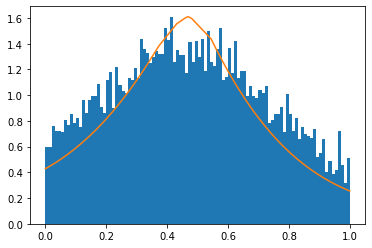

In [115]:
plt.hist(posterior_theta[0][:,1], bins=100, density=True)

plt.plot(np.sort(posterior_theta[0][:,1]),Lik_vals[np.argsort(posterior_theta[0][:,1])]/normalising_constant)
plt.show()

In [9]:

for l in range(len(posterior_theta[0])):
    individual_posterior = [np.atleast_2d(p[l]) for p in posterior_theta]
    u_best = BayesInference.u_function(y=PF_samples[0],
                            weights= posterior_weights[l], 
                            parameters = individual_posterior).reshape(-1)

    discretisation =5000
    y1 = np.linspace(lb, ub, 200)
    y2 = np.linspace(lb, ub, discretisation)
    y2_coordinate = []
    K = np.max(u_best)
    for y1_val in y1:

        y_joint = np.hstack((np.repeat(y1_val, discretisation).reshape(-1,1), y2.reshape(-1,1)))

        ucline = BayesInference.u_function(y = y_joint,
                weights= posterior_weights[l], 
                parameters = individual_posterior).reshape(-1)

        delta = np.abs(ucline - K)
        
        if np.min(delta)<1e-03:
            y2_coordinate.append(y2[np.argmin(delta)])
        else:
            y2_coordinate.append(y2[-1])

    plt.plot(y1, np.array(y2_coordinate).reshape(-1), color="red", linestyle='dashed')
    plt.scatter(PF_samples[0][np.argmax(u_best),0],PF_samples[0][np.argmax(u_best),1],color="magenta")

plt.xlim(lb, ub)
plt.ylim(lb, ub)
# plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/Acceptability surface: " + label[u] + ".png",bbox_inches='tight')
plt.show()

TypeError: __init__() missing 1 required positional argument: 'preferred_points'

In [250]:
preferred_points = np.random.random((100,2))*(ub - lb) + lb

BayesInference = Inference_method(assumed_function,
                                     Pareto_front=PF_samples,
                                     preferred_points=PF_decisions)
#pred_lik = BayesInference.predictive_distribution(PF_samples, preferred_points)

In [8]:
PF_samples

[array([[-1.52390947e+00,  2.33403648e-01],
        [ 1.03985404e-01, -1.66256807e+00],
        [ 1.03985404e-01, -1.66256807e+00],
        [-8.16914887e-01, -8.25584175e-02],
        [-9.06379810e-01, -2.87676592e-02],
        [-2.95226385e-02, -1.12230849e+00],
        [-5.94671098e-01, -2.49353789e-01],
        [-1.37529713e-01, -8.59202208e-01],
        [-1.35086044e+00,  1.79832746e-01],
        [-2.58164720e-01, -6.60313154e-01],
        [ 9.25835445e-02, -1.59695470e+00],
        [-1.30184900e+00,  1.59894248e-01],
        [-6.45167506e-01, -2.05957053e-01],
        [ 6.71580576e-02, -1.46878327e+00],
        [ 8.09554455e-02, -1.53500124e+00],
        [-1.07888621e+00,  6.73694586e-02],
        [-1.54440892e-01, -8.23597884e-01],
        [-1.04534996e+00,  5.10637060e-02],
        [-3.83960892e-01, -4.68370081e-01],
        [-4.55555089e-01, -3.84371846e-01],
        [ 7.78977373e-02, -1.52310280e+00],
        [-3.99835994e-01, -4.46403795e-01],
        [-1.16655493e-02, -1.168

In [9]:
PF_decisions

[51, 4, 39]

time to create samples 0.8110275268554688


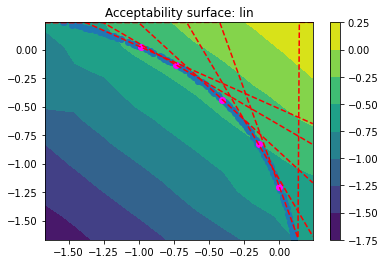

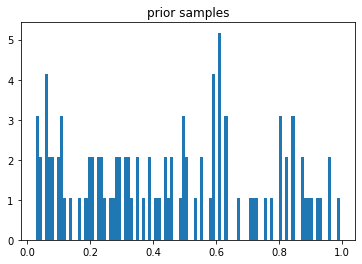

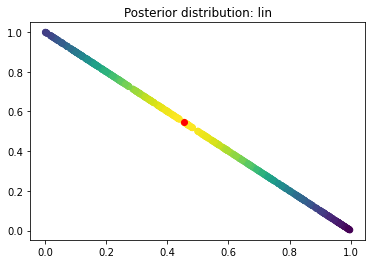

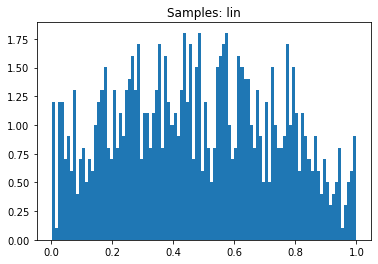

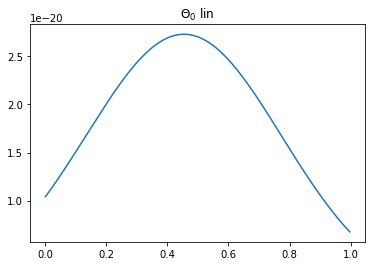

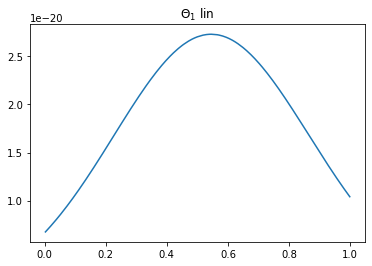

time to create samples 1.0126733779907227


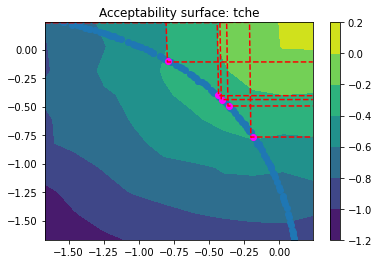

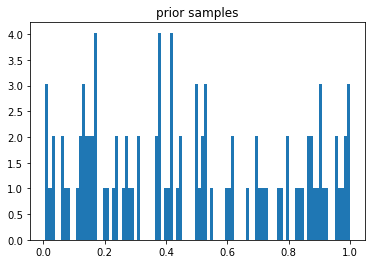

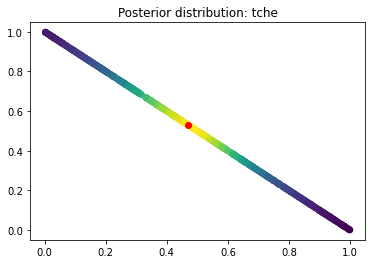

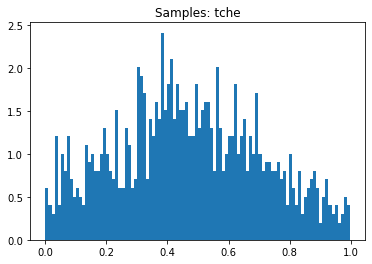

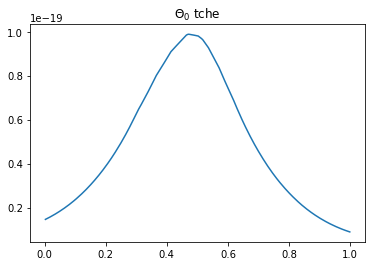

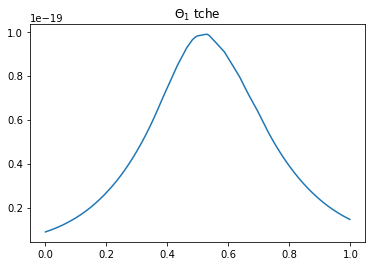

time to create samples 1.5050218105316162


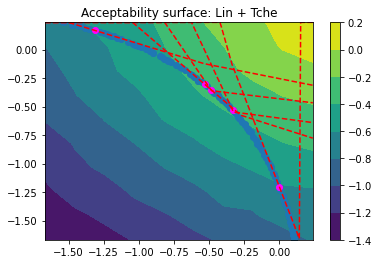

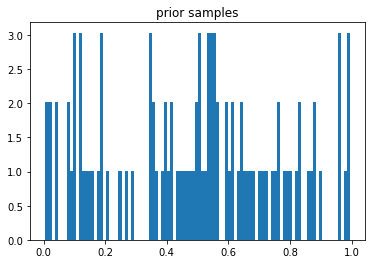

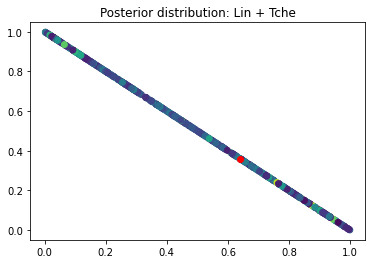

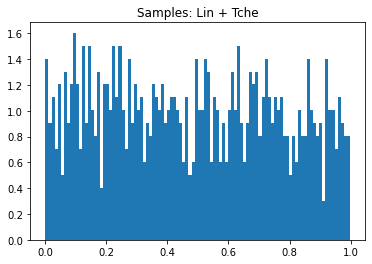

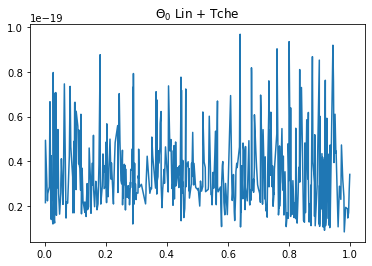

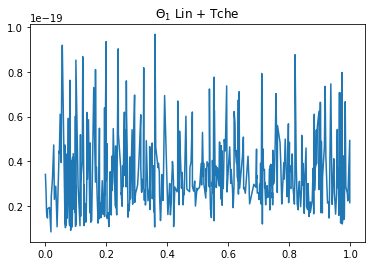

In [275]:
import time
Lin_u = Linear_utility_func(n_params=m)
Tche_u = Tchevichev_utility_func(n_params=m)

u_funcs = [[Lin_u], [Tche_u],[Lin_u, Tche_u]]#[Lin_u]#, 
label = ["lin", "tche", "Lin + Tche"]
Log_Likelihood_values = []
for u in range(len(u_funcs)):
    assumed_function = u_funcs[u]
    theta_samples, weight_samples = prior_sample_generator(assumed_function)(n_samples=500)#([np.array([[0.1, 0.9]])], np.array([[1.]])) ##true_theta, true_weight# 

    BayesInference = Inference_method(assumed_function,
                                         Pareto_front=PF_samples,
                                         preferred_points=PF_decisions)
    
    
    start = time.time()
    prior_vals = BayesInference.prior(theta_samples, weight_samples)
    Lik_vals= BayesInference.Likelihood(theta = theta_samples,
                                         weights = weight_samples, log=False)
    stop = time.time()
    

    start = time.time()
    prior_samples = BayesInference.prior_sampler(n_samples=100)
    posterior_samples = BayesInference.posterior_sampler(n_samples=1000)
    stop = time.time()
    print("time to create samples", stop-start)
    
    
#     print("marg samples", BayesInference.posterior_sampler(n_samples=1, seed=3))
    ub = np.max([np.max(PF_samples[0][:,0]),np.max(PF_samples[0][:,1])])
    lb = np.min([np.min(PF_samples[0][:,0]), np.min(PF_samples[0][:,1])])
    preferred_points = np.random.random((100,2))*(ub - lb) + lb
    
    xlist = np.linspace(lb, ub, 10)
    ylist = np.linspace(lb, ub, 10)
    xv, yv = np.meshgrid(xlist, ylist, sparse=False, indexing='ij')
    nx = len(xlist)
    ny = len(ylist)
    Z = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            preferred_points = np.array([xv[i,j], yv[i,j]]).reshape(-1)
            preferred_points = np.atleast_2d(preferred_points)
            pred_lik = BayesInference.predictive_distribution(PF_samples, preferred_points)
           
            Z[i,j] = pred_lik
    

    
    plt.title("Acceptability surface: " + label[u])
    im = plt.contourf(xv, yv, Z)
    plt.scatter(PF_samples[0][:,0], PF_samples[0][:,1])
    plt.colorbar(im)
    
    posterior_theta, posterior_weights =  BayesInference.posterior_sampler(n_samples=5, 
                                                            seed=2)
    
    for l in range(len(posterior_theta[0])):
        individual_posterior = [np.atleast_2d(p[l]) for p in posterior_theta]
        u_best = BayesInference.u_function(y=PF_samples[0],
                                weights= posterior_weights[l], 
                                parameters = individual_posterior).reshape(-1)

        discretisation =5000
        y1 = np.linspace(lb, ub, 200)
        y2 = np.linspace(lb, ub, discretisation)
        y2_coordinate = []
        K = np.max(u_best)
        for y1_val in y1:

            y_joint = np.hstack((np.repeat(y1_val, discretisation).reshape(-1,1), y2.reshape(-1,1)))

            ucline = BayesInference.u_function(y = y_joint,
                    weights= posterior_weights[l], 
                    parameters = individual_posterior).reshape(-1)

            delta = np.abs(ucline - K)

            if np.min(delta)<1e-03:
                y2_coordinate.append(y2[np.argmin(delta)])
            else:
                y2_coordinate.append(y2[-1])

        plt.plot(y1, np.array(y2_coordinate).reshape(-1), color="red", linestyle='dashed')
        plt.scatter(PF_samples[0][np.argmax(u_best),0],PF_samples[0][np.argmax(u_best),1],color="magenta")

    plt.xlim(lb, ub)
    plt.ylim(lb, ub)
    plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/Acceptability surface: " + label[u] + ".png",bbox_inches='tight')
    plt.show()
  
    plt.title("prior samples")
    plt.hist(prior_samples[0][0][:,0], bins=100,density=True)
    plt.show()
    
    Log_Likelihood_values.append(np.max(Lik_vals))
    plt.title("Posterior distribution: "+ label[u])
    plt.scatter(theta_samples[0][:,0],theta_samples[0][:,1], c=Lik_vals)
    plt.scatter(theta_samples[0][np.argmax(Lik_vals), 0], theta_samples[0][np.argmax(Lik_vals), 1], color="red")
#     plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/posterior_distribution_theta.png",bbox_inches='tight')
    plt.show()
   
    plt.title("Samples: " +label[u])
    plt.hist(posterior_samples[0][0][:,0], bins=100,density=True)
    plt.show()
    
    
    plt.title("$\Theta_{0}$ " +label[u])
    plt.plot(np.sort(theta_samples[0][:,0]),Lik_vals[np.argsort(theta_samples[0][:,0])])
#     plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/marg_0_distribution_theta.png",bbox_inches='tight')
    plt.show()

    plt.title("$\Theta_{1}$ " +label[u])
    plt.plot(np.sort(theta_samples[0][:,1]),Lik_vals[np.argsort(theta_samples[0][:,1])])
#     plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/marg_1_distribution_theta.png",bbox_inches='tight')
    plt.show()
  
    #print(Lik_vals)

In [ ]:

posterior_samples = BayesInference.posterior_sampler(n_samples=10000, warmup=100)

start = time.time()
theta1, retstep  = np.linspace(0,1,500, retstep=True)
theta2 = 1-theta1

theta_samples= [np.hstack((theta1.reshape(-1,1), theta2.reshape(-1,1)))]
Lik_vals= BayesInference.Likelihood(theta = theta_samples,
                                     weights = weight_samples, log=False)
stop = time.time()



Norm_const = np.sum(Lik_vals*retstep)

plt.title("$\Theta_{0}$ " +label[u])
plt.plot(theta1 , Lik_vals/Norm_const)
plt.hist(posterior_samples[0][0][:,0], bins=100,density=True)
# plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/marg_0_distribution_theta.png",bbox_inches='tight')
plt.show()

plt.title("$\Theta_{1}$ " + label[u])
plt.plot(theta2 , Lik_vals/Norm_const)
plt.hist(posterior_samples[0][0][:,1], bins=100,density=True)
# plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/marg_1_distribution_theta.png",bbox_inches='tight')
plt.show()

In [171]:
posterior_samples[0][0].shape

(100, 2)

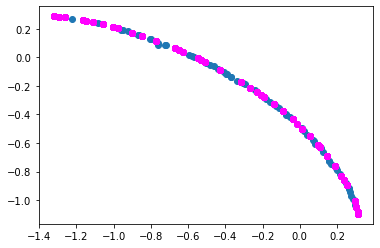

In [118]:
posterior_theta, posterior_weights =  BayesInference.posterior_sampler(n_samples=1000, 
                                                        seed=None)
plt.scatter(PF_samples[0][:,0], PF_samples[0][:,1])
for l in range(len(posterior_theta[0])):
    
    u_best = BayesInference.u_function(y=PF_samples[0],
                            weights= posterior_weights[0], 
                            parameters = posterior_theta[0][l]).reshape(-1)
    
  
    plt.scatter(PF_samples[0][np.argmax(u_best),0],PF_samples[0][np.argmax(u_best),1],color="magenta")


plt.show()

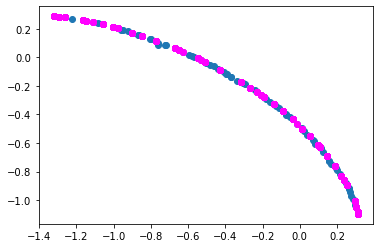

In [112]:
posterior_theta, posterior_weights =  BayesInference.prior_sampler(n_samples=1000, 
                                                        seed=None)
plt.scatter(PF_samples[0][:,0], PF_samples[0][:,1])
for l in range(len(posterior_theta[0])):
    
    u_best = BayesInference.u_function(y=PF_samples[0],
                            weights= posterior_weights[0], 
                            parameters = posterior_theta[0][l]).reshape(-1)
    
  
    plt.scatter(PF_samples[0][np.argmax(u_best),0],PF_samples[0][np.argmax(u_best),1],color="magenta")


plt.show()

array([0.41395313, 0.58604687])

In [17]:
np.argmax(np.sum(PF_samples[0]*posterior_theta[0][-2]))

0

In [ ]:
posterior_weights[0]


$$
\overbrace{\text{P}(\theta_{\mathscr{M}}  | Data )}^{Posterior}  = \frac{\overbrace{\text{P}(Data| \theta_{\mathscr{M} } ,  \mathscr{M} )}^{Likelihood} \overbrace{\text{P}(\theta_{\mathscr{M} })}^{Prior}}{\underbrace{\text{P}(Data | \mathscr{M})}_{Evidence}}
$$

$$
\text{P}(Data | \mathscr{M}_{Lin})
$$

$$
\text{P}(Data | \mathscr{M}_{Tche})
$$

$$
\text{P}(Data | \mathscr{M}_{Lin+Tche})
$$

$$
\text{BIC} = \text{log}\big(\text{P}(Data| \hat{\theta}_{\mathscr{M} } ,  \mathscr{M} )\big) -  \frac{Dim(\theta)\text{log}(N)}{2}
$$

$$
\text{P}((y^{*}_{pref}, Y^{*}_{PF})|   \mathscr{M} ) = \int \text{P}((y^{*}_{pref}, Y^{*}_{PF})| \theta_{\mathscr{M} } ,  \mathscr{M} ) \text{P}(\theta_{\mathscr{M}}  | Data ) d \theta
$$

In [ ]:
x = np.linspace(-4,2,100)

y = 2*norm.cdf(x).reshape(-1,1)
y_ext = np.hstack([y, np.ones(y.shape)])
y = np.min(y_ext,axis=1)
plt.plot(x, y)
plt.xlabel("$\mathscr{L}(Data, \Theta)$")
plt.ylabel("$\mathbb{P}(Data| \Theta)$")
plt.hlines(1, -4,0, color="red", linestyles="--")
plt.vlines(-0.7,0,0.50, color="magenta", linestyles="--")
plt.hlines(0.5,-4,-0.7, color="magenta", linestyles="--")
plt.ylim(0,1.1)
plt.xlim(-4,1)

$$
\text{P}(Data | \theta_{\mathscr{M} }, \mathscr{M}) = \text{min} \{2  \Phi (\mathscr{L}(Data, \theta)) , 1 \}
$$

$$
\mathscr{L}(Data, \theta) = U_{\mathscr{M}}(y_{Pref}; \theta) - \max_{y \in Y_{pf}} \{U_{\mathscr{M}}(y; \theta)\}
$$

$$
\mathscr{L}(Data, \theta) = 0 \text{; If } U_{\mathscr{M}}(y_{Pref}; \theta)  = \max_{y \in Y_{pf}} \{U_{\mathscr{M}}(y; \theta)\}
$$

$$
\mathscr{L}(Data, \theta) > 0\text{; If } U_{\mathscr{M}}(y_{Pref}; \theta)  < \max_{y \in Y_{pf}} \{U_{\mathscr{M}}(y; \theta)\}
$$



In [ ]:
dim = np.array([2 , 2, 6]).reshape(-1)
BIC = np.array(Log_Likelihood_values).reshape(-1) - (dim/2)*np.log(len(PF_decisions))

In [ ]:
norm_BIC = BIC#/ np.sum(BIC)
plt.bar(label, -norm_BIC)
plt.title("negative BIC")
plt.ylabel("$-$ BIC")
plt.xlabel("model")

plt.savefig("/home/juan/Documents/repos_data/ParEGO_Last_STEP/Pics/plots_BIC_criteria/BIC.png",bbox_inches='tight')